<a href="https://colab.research.google.com/github/huskeypm/tutorials/blob/master/tsne_cellsorting/pandas_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pandas + tsne on cytoflow data

***i need to update this for umap***
* also use data that has different test conditions so we can apply anova
* Commit to repo


## Load/install important things

### Installing FCS parser
Note: fcsparser 'downgrades' some libraries installed by default. For this reason, we need to first install, then restart the session
- Run Step 1: pip install fcsparser.
    - You will get an error and potentially a prompt to restart the session.  
    - restart the session (under Runtime), but **not** disconnect/delete runtime
- Run Step 2:
    - don't redo step 1
- Profit




In [ ]:
# Step 1:
!pip install fcsparser

In [ ]:
# Step 2
import fcsparser

### Import other libs

In [ ]:
import numpy as np
#from sklearn.datasets import load_digits
#from scipy.spatial.distance import pdist
#from sklearn.manifold.t_sne import _joint_probabilities
#from scipy import linalg
#from sklearn.metrics import pairwise_distances
#from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#palette = sns.color_palette("bright", 10)
import pandas as pd
import os

In [ ]:
%matplotlib inline

## Pandas time!

### download test
* data from  /home/pkekeneshuskey/DataLocker/flowcyto/raiza/DIR
* 1906188_Tube_045_4L_WD_DRG.fcs available at https://drive.google.com/file/d/1qT2Sh9bYALXA7pPu_1EDmUhVp0vjmGPm/view


DIR=fmt,vehicle

In [ ]:
path = "." # on colab
nSamples = 1000 # 3000

## Function for normalizing data
(we will use this later)
- finds all entries below a threshold and sets to that threshold
- applies log to all entries
- fills any missing cells with 0

In [ ]:
def doRenorm(frame):
  frame[frame < 1e-9] = 1e-9      # verify all numbers are positive
  frame = frame.apply(np.log10)  # convert all into log
  frame=frame.fillna(0)
  frame[frame<0]=0

  # computes the median for all channels in data set
  print("Channel, mean")
  for channel in frame.keys():
      print(channel,np.median(frame[channel]))
  return frame


## Load data via funky parser (returns pandas object)
- we'll take a subset to keep life pleasant
- dapply renormalization

In [ ]:

fileNames = ["1906188_Tube_045_4L_WD_DRG.fcs"]
#metadata, df = fcsparser.parse(
#    os.path.join(path, fileNames[0])
#)

renorm=True
randFromSet = True
#sample = fct.FCMeasurement(ID='Test Sample', datafile=path+"/" + fileName)
metadata, df = fcsparser.parse(
    os.path.join(path, fileNames[0])
)

sample = df
if randFromSet:
  sample = sample.sample(nSamples)  # get 1K random entries

if renorm:
  sample = doRenorm(sample)

Channel, mean
FSC-A 4.4479628
FSC-H 4.1914372
FSC-W 5.0722713
SSC-A 4.17935
MHC II 2.6705194013741727
ACETYL-K 1.8936508102135488
CD45 3.0303446539332435
CD11B 2.605821749337017
F4/80 1.908645832364541
CD206 1.9530828542480163
Time 3.824145


/tmp/ipython-input-1188448175.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1e-09' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  frame[frame < 1e-9] = 1e-9      # verify all numbers are positive


## Explore the data
Get the second key from the list (FSC-W); display that column

In [ ]:
key = sample.keys()[2]
sample[key]

,FSC-W
17261,4.954003
12794,4.896355
6384,5.160715
18564,5.155303
15056,4.910874
...,...
17141,4.923874
10980,4.974806
10692,5.418538
17688,4.958127


### compare stats for full version.

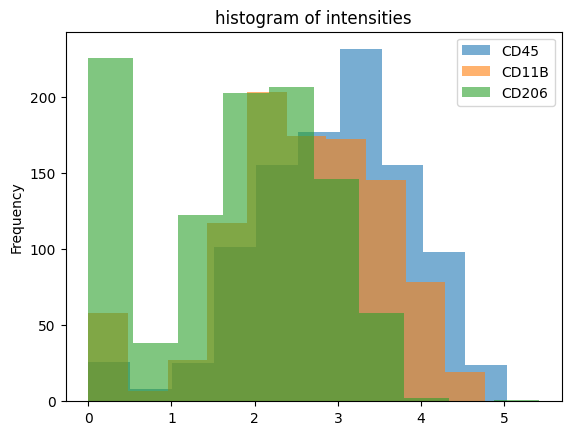

In [ ]:
#subset = sample.keys()[0:3]
subset=['CD45','CD11B','CD206']
plt.title('histogram of intensities')
for channel in subset:
    try:
        ax = sample[channel].plot.hist(label=channel, alpha=0.6)
        ax.legend()

    except:
        print(f"{channel} not found")

How do 'CD45' and 'CD11B' co-distribute

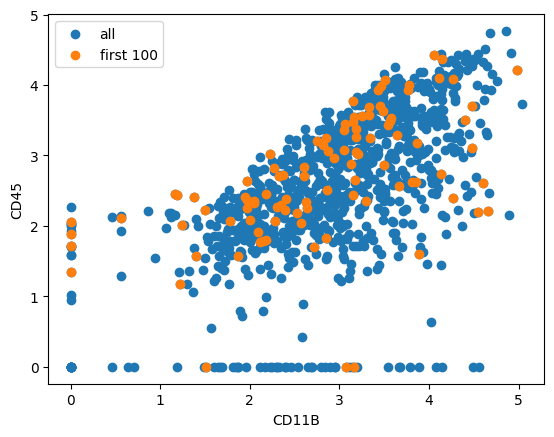

In [ ]:
channel1 = 'CD45'
channel2 = 'CD11B'
import seaborn as sns

# plot all
plt.scatter(sample[channel1],sample[channel2],label="all")

# plot subset (first 100:)
plt.scatter(sample[channel1][:100],sample[channel2][:100], label="first 100")
plt.xlabel(channel2)
plt.ylabel(channel1)

plt.legend(loc=0)

## Misc examples

In [ ]:
# Create a new column named adjusted.
sample["test"] = sample["CD45"] + 2
print(sample.keys())

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'MHC II', 'ACETYL-K', 'CD45',
       'CD11B', 'F4/80', 'CD206', 'Time', 'test'],
      dtype='object')


Define a function, apply to all cells within a column

In [ ]:
def myCoolFunction(x):
  return x * x

sample['applied'] = sample['CD45'].apply(myCoolFunction)

print("Original 'CD45' column (first 5 rows):")
print(sample['CD45'].head())
print("\nNew 'applied' column (first 5 rows):")
print(sample['applied'].head())

Original 'CD45' column (first 5 rows):
17261    2.086039
12794    3.161302
6384     2.369828
18564    2.938870
15056    0.562293
Name: CD45, dtype: float64

New 'applied' column (first 5 rows):
17261    4.351560
12794    9.993831
6384     5.616084
18564    8.636956
15056    0.316173
Name: applied, dtype: float64


In [ ]:
print( np.average(sample['CD45']))

print( np.average(sample['test']))

2.9284568396847326
4.928456839684733


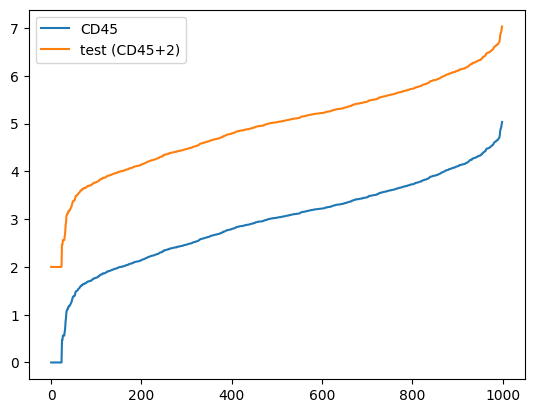

In [ ]:
sorted = np.sort( sample['CD45'])
plt.plot(sorted, label='CD45')

sorted = np.sort( sample['test'])
plt.plot(sorted, label='test (CD45+2)')
plt.legend(loc=0)

'Gating' cell populations
- plot cd45 expr in all cells
- mark those with side-scatter (measure of 'granularity') above a value [isolate different cells]

Text(0, 0.5, 'CD45')

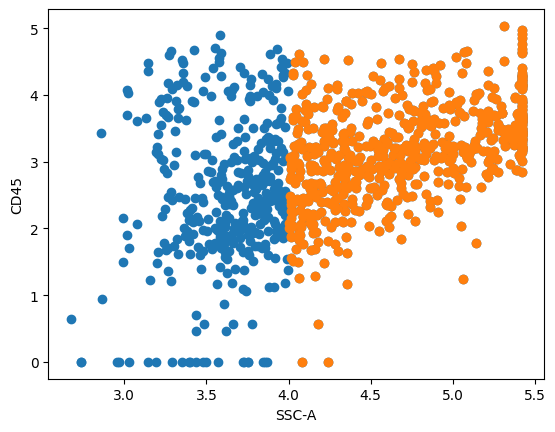

In [ ]:
channel = 'CD45'
channel2 = 'SSC-A'
subset = sample.loc[
  sample[channel2] > 4   # just for testing
]
# get indices
idxSubset= subset.index.values
characteristic = subset[channel]

# plot data (all)
xAxis = sample[channel2]
yAxis = sample[channel]
plt.scatter(xAxis,yAxis)

# plot data (subset)
xAxis = sample[channel2][idxSubset]
yAxis = sample[channel][idxSubset]
plt.scatter(xAxis,yAxis)
plt.xlabel(channel2)
plt.ylabel(channel)

### ANOVA example
* “melts” the DataFrame (wide → long) for three columns: 'CD45', 'CD206', 'CD11B'. (needed for seaborn fancy plotting)
* null hypothesis is that the three groups (CD45, CD206, CD11B) all have the same population mean [sorta meaningless here]


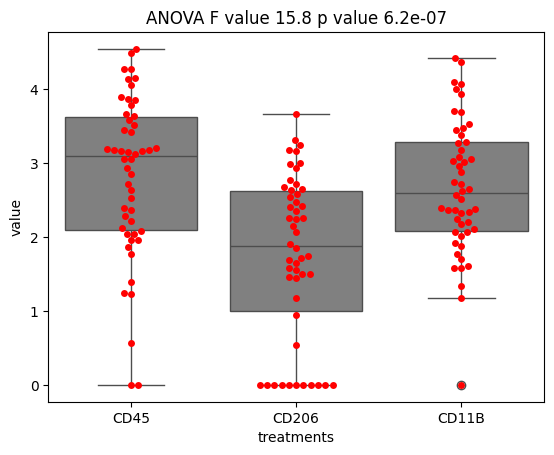

In [ ]:
from scipy.stats import f_oneway
df = sample[0:50]
df_melt = pd.melt( df.reset_index(),
                  id_vars=['index'],value_vars=['CD45','CD206','CD11B'])
df_melt.columns = ['index', 'treatments', 'value']
ax = sns.boxplot(x='treatments', y='value', data=df_melt,color="gray")
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='red')

fvalue, pvalue = f_oneway(df['CD45'], df['CD206'],df['CD11B'])
plt.title("ANOVA F value %4.1f p value %2.1e"%(fvalue, pvalue))

plt.gcf().savefig("anova.png",dpi=300)


In [ ]:
sample.to_csv("out.csv")

# TSNE
* Grab channels of interest, reset index

In [ ]:
Xw = sample[['CD45','FSC-A','SSC-A']]
Xw = Xw.reset_index(drop=True)
Xw.tail()

,CD45,FSC-A,SSC-A
995,4.299279,4.287922,3.963300
996,3.185335,4.121453,3.812729
997,3.000677,5.320103,5.110601
998,2.383151,4.271981,3.783836
999,3.731497,4.445446,5.300126


### Relabel data for indexing later

## tsne
- This is a technique for projecting data into clusters (by their attributes)
- Takes about a minute for ~2K points

In [ ]:
tsne = TSNE()
X_embedded = tsne.fit_transform(Xw)

## Define function for plotting data

In [ ]:
# plot all data (no characteristics)
from scipy.stats import kde
from scipy.stats import gaussian_kde
def PlotData(
    X,             # original data
    X_embedded,    # tsne'd data
    channel='SSC-A',# which channel to select for
    channelThresh = 0, # threshold
    allData = True # display 'all' data on background, plot 'key' data on foreground
    ):

    # plot background
    plt.figure()
    if allData:
      nbins=300
      x,y = X_embedded[:,0], X_embedded[:,1]
      k = gaussian_kde([x,y])
      xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
      zi = k(np.vstack([xi.flatten(), yi.flatten()]))

      # Make the plot
      plt.pcolormesh(xi, yi, zi.reshape(xi.shape),cmap="binary")

      #sns.scatterplot(X_`embedded[:,0], X_embedded[:,1],
       #             facecolors='gray') # , characteristic)

      subset = X.loc[
          X[channel] > channelThresh   # just for testing
      ]
      characteristic = subset[channel]

      idxSubset= subset.index.values
      #print(subset[channel])


      xAxis = X_embedded[idxSubset,0]
      yAxis = X_embedded[idxSubset,1]

      #sns.scatterplot(X_embedded[idxSubset],x=xAxis,y=yAxis,hue=characteristic)#,hue_norm=True)
      sns.scatterplot(X,x=X_embedded[:,0],y=X_embedded[:,1]) # ,hue=characteristic)#,hue_norm=True)
      sns.scatterplot(subset,x=xAxis,y=yAxis,hue=characteristic)#,hue_norm=True)





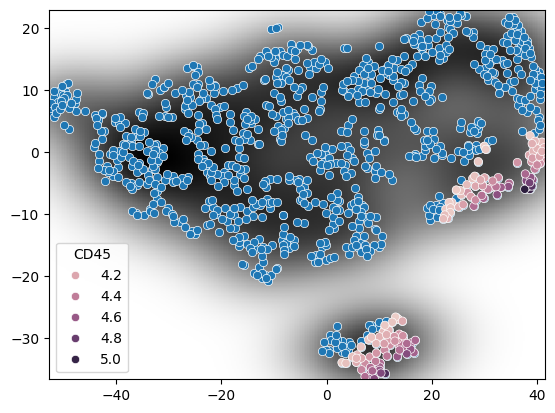

In [ ]:
channel = "CD45"
PlotData(Xw,X_embedded,channel=channel, channelThresh=4,allData=True)#
